In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold,KFold,GridSearchCV,GroupKFold,train_test_split
from rfpimp import *
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

/home/arya/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')

In [3]:
df_sub = pd.read_excel('Sample_Submission.xlsx')

Lets see some stats of training and test set

In [4]:
for x in df_train.columns:
    print(df_train[x].value_counts(normalize=True))

1    0.682790
2    0.287964
0    0.029246
Name: Gender, dtype: float64
0    0.87964
1    0.12036
Name: Chain_smoker, dtype: float64
1    0.83802
0    0.16198
Name: Consumes_other_tobacco_products, dtype: float64
0    0.913386
1    0.086614
Name: HighBP, dtype: float64
1    0.91901
0    0.08099
Name: Obese, dtype: float64
0    0.944882
1    0.055118
Name: Diabetes, dtype: float64
0    0.957255
1    0.042745
Name: Metabolic_syndrome, dtype: float64
0    0.917885
1    0.082115
Name: Use_of_stimulant_drugs, dtype: float64
1    0.925759
0    0.074241
Name: Family_history, dtype: float64
0    0.982002
1    0.017998
Name: History_of_preeclampsia, dtype: float64
0    0.978628
1    0.021372
Name: CABG_history, dtype: float64
0    0.967379
1    0.032621
Name: Respiratory_illness, dtype: float64
no     0.786277
yes    0.213723
Name: UnderRisk, dtype: float64


In [5]:
for x in df_test.columns:
    print(df_test[x].value_counts(normalize=True))

1    0.651832
2    0.321990
0    0.026178
Name: Gender, dtype: float64
0    0.879581
1    0.120419
Name: Chain_smoker, dtype: float64
1    0.793194
0    0.206806
Name: Consumes_other_tobacco_products, dtype: float64
0    0.945026
1    0.054974
Name: HighBP, dtype: float64
1    0.89267
0    0.10733
Name: Obese, dtype: float64
0    0.947644
1    0.052356
Name: Diabetes, dtype: float64
0    0.939791
1    0.060209
Name: Metabolic_syndrome, dtype: float64
0    0.89267
1    0.10733
Name: Use_of_stimulant_drugs, dtype: float64
1    0.924084
0    0.075916
Name: Family_history, dtype: float64
0    0.994764
1    0.005236
Name: History_of_preeclampsia, dtype: float64
0    0.979058
1    0.020942
Name: CABG_history, dtype: float64
0    0.968586
1    0.031414
Name: Respiratory_illness, dtype: float64


Looks the same to me not much of difference, probably a straifiedkfold should be enough

In [6]:
df_train[df_train['Gender'] == 0]['UnderRisk'].value_counts(normalize=True)

no     0.846154
yes    0.153846
Name: UnderRisk, dtype: float64

In [7]:
df_train[df_train['Gender'] == 1]['UnderRisk'].value_counts(normalize=True)

no     0.759473
yes    0.240527
Name: UnderRisk, dtype: float64

In [8]:
df_train[df_train['Gender'] == 2]['UnderRisk'].value_counts(normalize=True)

no     0.84375
yes    0.15625
Name: UnderRisk, dtype: float64

Similary as above i tried to see of there are some definite relationships of the features with the target so that i can just create a rule but there didn't seem to be any.

In [12]:
risk = {
    'no':0,
    'yes':1
}
df_train['UnderRisk'] = df_train['UnderRisk'].map(risk)

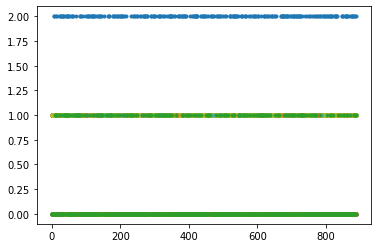

In [13]:
plt.plot(df_train,' .')

This is just my way of seeing how the data was separated , like by what column or by what value row wise, x is row indices and y is a column seems like it was separated via gender.

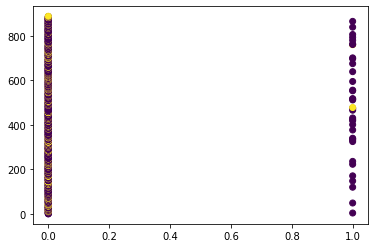

In [19]:
plt.scatter(x=df_train.values[:,6],y=range(len(df_train)),c=df_train['UnderRisk'])

Just trying to see if there are variables that can get me good class separation but there isnt any i mean, thats probably the red flag that this data doesnt need much parameter tuning and feature engineering is just impossible here and also i have to remove noise because that will actually make my model unstable .

In [22]:
best = ['Family_history',
 'HighBP',
 'Chain_smoker',
 'Metabolic_syndrome',
 'Gender',
 'Obese']

Using Feature Importance i got the best features as above

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(df_train.drop('UnderRisk',axis=1),df_train['UnderRisk'],stratify=df_train['UnderRisk'],random_state=22)

In [23]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)
predictions = np.zeros((len(X_valid), 2))
oof_preds = np.zeros((len(df_test), 2))
feature_importance_df = pd.DataFrame()
final_preds = []
# random_state = [77,89,22,1007,1997,1890,2000,2020,8989,786,787,1999992,2021,7654]
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
        print("Fold {}".format(fold_))
        X_trn,y_trn = X_train[best].iloc[trn_idx],y_train.iloc[trn_idx]
        X_val,y_val = X_train[best].iloc[val_idx],y_train.iloc[val_idx]
        clf  = lgb.LGBMClassifier(random_state=22,learning_rate=0.01,n_estimators=4000)
        clf.fit(X_trn, y_trn, eval_metric="logloss", eval_set=[(X_val,y_val)], verbose=True,early_stopping_rounds=100)
        final_preds.append(log_loss(y_pred=clf.predict_proba(X_val),y_true=y_val))
        predictions += clf.predict_proba(X_valid[best])
#         oof_preds += clf_lgb.predict_proba(df_test[k])
#         counter = counter + 1
# oof_preds = oof_preds/counter
print(sum(final_preds)/5)

Fold 0
[1]	valid_0's binary_logloss: 0.521521
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.520671
[3]	valid_0's binary_logloss: 0.519836
[4]	valid_0's binary_logloss: 0.519014
[5]	valid_0's binary_logloss: 0.518206
[6]	valid_0's binary_logloss: 0.517411
[7]	valid_0's binary_logloss: 0.51663
[8]	valid_0's binary_logloss: 0.51586
[9]	valid_0's binary_logloss: 0.515104
[10]	valid_0's binary_logloss: 0.514359
[11]	valid_0's binary_logloss: 0.513626
[12]	valid_0's binary_logloss: 0.512905
[13]	valid_0's binary_logloss: 0.512195
[14]	valid_0's binary_logloss: 0.511496
[15]	valid_0's binary_logloss: 0.510808
[16]	valid_0's binary_logloss: 0.510131
[17]	valid_0's binary_logloss: 0.509464
[18]	valid_0's binary_logloss: 0.508807
[19]	valid_0's binary_logloss: 0.508161
[20]	valid_0's binary_logloss: 0.507524
[21]	valid_0's binary_logloss: 0.506897
[22]	valid_0's binary_logloss: 0.506279
[23]	valid_0's binary_logloss: 0.505671
[24]	valid_0's binary_

[70]	valid_0's binary_logloss: 0.498315
[71]	valid_0's binary_logloss: 0.498236
[72]	valid_0's binary_logloss: 0.498159
[73]	valid_0's binary_logloss: 0.498084
[74]	valid_0's binary_logloss: 0.498012
[75]	valid_0's binary_logloss: 0.497941
[76]	valid_0's binary_logloss: 0.497873
[77]	valid_0's binary_logloss: 0.497808
[78]	valid_0's binary_logloss: 0.497744
[79]	valid_0's binary_logloss: 0.497682
[80]	valid_0's binary_logloss: 0.497622
[81]	valid_0's binary_logloss: 0.497565
[82]	valid_0's binary_logloss: 0.497509
[83]	valid_0's binary_logloss: 0.497455
[84]	valid_0's binary_logloss: 0.497403
[85]	valid_0's binary_logloss: 0.497353
[86]	valid_0's binary_logloss: 0.497304
[87]	valid_0's binary_logloss: 0.497256
[88]	valid_0's binary_logloss: 0.49721
[89]	valid_0's binary_logloss: 0.497165
[90]	valid_0's binary_logloss: 0.497122
[91]	valid_0's binary_logloss: 0.497081
[92]	valid_0's binary_logloss: 0.497041
[93]	valid_0's binary_logloss: 0.497003
[94]	valid_0's binary_logloss: 0.496966
[

Fold 4
[1]	valid_0's binary_logloss: 0.513848
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.513025
[3]	valid_0's binary_logloss: 0.512216
[4]	valid_0's binary_logloss: 0.51142
[5]	valid_0's binary_logloss: 0.510639
[6]	valid_0's binary_logloss: 0.509871
[7]	valid_0's binary_logloss: 0.509116
[8]	valid_0's binary_logloss: 0.508373
[9]	valid_0's binary_logloss: 0.507643
[10]	valid_0's binary_logloss: 0.506925
[11]	valid_0's binary_logloss: 0.506219
[12]	valid_0's binary_logloss: 0.505524
[13]	valid_0's binary_logloss: 0.504841
[14]	valid_0's binary_logloss: 0.504169
[15]	valid_0's binary_logloss: 0.503508
[16]	valid_0's binary_logloss: 0.502857
[17]	valid_0's binary_logloss: 0.502216
[18]	valid_0's binary_logloss: 0.501586
[19]	valid_0's binary_logloss: 0.500966
[20]	valid_0's binary_logloss: 0.500355
[21]	valid_0's binary_logloss: 0.499754
[22]	valid_0's binary_logloss: 0.499162
[23]	valid_0's binary_logloss: 0.498579
[24]	valid_0's binary

In [24]:
print(log_loss(y_pred=predictions/5,y_true=y_valid))

0.4813758395132681


This Gave me the best Leaderboard Score , i also tried training the model and trying to average out the results using different random states but it just didnt really work. 

In [27]:
df_sub['no'] = y_preds[:,0]
df_sub['yes'] = y_preds[:,1]
df_sub.to_excel('Blended.xlsx',index=False)